In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [2]:
files_gamma = os.listdir("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/gammas/numpy_v1/")
files_ele = os.listdir("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v1/")

In [3]:
print(f"N gamma files: {len(files_gamma)}")
print(f"N ele files: {len(files_ele)}")

N gamma files: 92
N ele files: 46


In [4]:
datas = []

for i in range(1, 35):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v1/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    outsc = d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == False)]
    insc =  d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == True)]    
    outsc = outsc.iloc[:len(insc)*5]
    datas += [insc, outsc]
    
data_ele = pd.concat(datas, ignore_index=True)
data_ele["particle"] = "electron"

In [5]:
datas = []

for i in range(1, 60):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/gammas/numpy_v1/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    outsc = d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == False)]
    insc =  d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == True)]    
    outsc = outsc.iloc[:len(insc)*5]
    datas += [insc, outsc]
    
data_gamma = pd.concat(datas, ignore_index=True)
data_gamma["particle"] = "gamma"

Balance gamma and electron

In [37]:
pickle.dump(data_gamma, open("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/gamma_cluster.npy", "wb"))

In [6]:
data = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)

In [7]:
insc = data[data.in_scluster]
outsc = data[(data.in_scluster == False)]

In [8]:
print("N in supercluster: ", len(insc))
print("N out supercluster: ", len(outsc))

N in supercluster:  877619
N out supercluster:  4385161


In [9]:
print("electron:" , len(data_ele))
print("gamma: ", len(data_gamma))

electron: 2631390
gamma:  2879172


## Check plots

(array([[1.265091  , 0.93388692, 1.1999361 , ..., 0.92845734, 1.04247842,
         0.96917916],
        [1.21622483, 1.21079525, 1.05605236, ..., 0.82258063, 0.9827531 ,
         0.96103479],
        [1.08862981, 1.04519321, 1.08862981, ..., 0.86873202, 0.98546788,
         0.99089746],
        ...,
        [1.0913446 , 1.05333757, 1.12663684, ..., 0.93117213, 1.15106992,
         1.02347491],
        [1.31395718, 1.05876715, 1.16192907, ..., 0.84972851, 0.99904182,
         1.01804533],
        [1.18636216, 1.08862981, 1.21893961, ..., 0.93117213, 1.14021077,
         0.91759819]]),
 array([-6.99999958e-01, -6.85999963e-01, -6.71999968e-01, -6.57999972e-01,
        -6.43999977e-01, -6.29999982e-01, -6.15999987e-01, -6.01999991e-01,
        -5.87999996e-01, -5.74000001e-01, -5.60000005e-01, -5.46000010e-01,
        -5.32000015e-01, -5.18000019e-01, -5.04000024e-01, -4.90000029e-01,
        -4.76000034e-01, -4.62000038e-01, -4.48000043e-01, -4.34000048e-01,
        -4.20000052e-01, -4.0

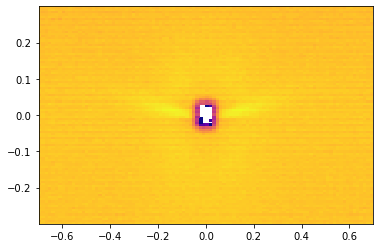

In [11]:
plt.hist2d(outsc.cluster_dphi, outsc.cluster_deta, 
           density=True, bins=(100,100),cmap="plasma", norm=colors.LogNorm())

## Weights by DeltaPhi

In [12]:
data.columns

Index(['cluster_deta', 'cluster_dphi', 'cluster_iz', 'en_cluster', 'en_seed',
       'en_true', 'in_scluster', 'index', 'is_calo', 'is_seed',
       'max_dr_cluster', 'max_en_cluster', 'nclusters', 'seed_eta', 'seed_iz',
       'seed_phi', 'window_index', 'particle'],
      dtype='object')

In [13]:
cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster"]

In [14]:
X = data[ cols ].values
truth = data[["in_scluster", "nclusters"]].values
y = np.array(truth[:,0], dtype=int)
#train_weights = data.train_weight.values

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open("../models/scaler_model9.pkl", "wb"))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.17)

In [18]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [19]:
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
training_generator, steps_per_epoch_train = balanced_batch_generator(X_train, y_train,  batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val = balanced_batch_generator(X_val, y_val, batch_size=1024, sampler=RandomOverSampler())

Using TensorFlow backend.


# Training

In [20]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

In [41]:
model = Sequential()
model.add(Dense(100, input_dim=7, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               800       
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_10 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                4050      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 51        
Total para

In [42]:
auto_save = ModelCheckpoint("../models/model11_balanced_100_80_50.hd5", monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=5)

#early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, 
#                            patience=10, verbose=1)

history = model.fit_generator(
            training_generator, 
            epochs=200,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks = [auto_save]
            )

Epoch 1/200
7109/7109 [==============================] - 47s 7ms/step - loss: 0.1182 - acc: 0.9548 - val_loss: 0.0900 - val_acc: 0.9656
Epoch 2/200
7109/7109 [==============================] - 46s 6ms/step - loss: 0.0991 - acc: 0.9623 - val_loss: 0.0879 - val_acc: 0.9661
Epoch 3/200
7109/7109 [==============================] - 54s 8ms/step - loss: 0.0972 - acc: 0.9631 - val_loss: 0.0879 - val_acc: 0.9658
Epoch 4/200
7109/7109 [==============================] - 47s 7ms/step - loss: 0.0962 - acc: 0.9634 - val_loss: 0.0870 - val_acc: 0.9663
Epoch 5/200
7109/7109 [==============================] - 51s 7ms/step - loss: 0.0956 - acc: 0.9636 - val_loss: 0.0871 - val_acc: 0.9663

Epoch 00005: val_loss improved from inf to 0.08710, saving model to ../models/model11_balanced_100_80_50.hd5
Epoch 6/200
7109/7109 [==============================] - 51s 7ms/step - loss: 0.0952 - acc: 0.9637 - val_loss: 0.0870 - val_acc: 0.9662
Epoch 7/200
7109/7109 [==============================] - 49s 7ms/step - lo

Epoch 55/200
7109/7109 [==============================] - 53s 8ms/step - loss: 0.0911 - acc: 0.9653 - val_loss: 0.0867 - val_acc: 0.9665

Epoch 00055: val_loss did not improve from 0.08614
Epoch 56/200
7109/7109 [==============================] - 52s 7ms/step - loss: 0.0912 - acc: 0.9652 - val_loss: 0.0867 - val_acc: 0.9665
Epoch 57/200
7109/7109 [==============================] - 53s 8ms/step - loss: 0.0909 - acc: 0.9653 - val_loss: 0.0863 - val_acc: 0.9666
Epoch 58/200
7109/7109 [==============================] - 52s 7ms/step - loss: 0.0910 - acc: 0.9653 - val_loss: 0.0864 - val_acc: 0.9667
Epoch 59/200
7109/7109 [==============================] - 47s 7ms/step - loss: 0.0909 - acc: 0.9654 - val_loss: 0.0864 - val_acc: 0.9666
Epoch 60/200
7109/7109 [==============================] - 46s 6ms/step - loss: 0.0909 - acc: 0.9654 - val_loss: 0.0870 - val_acc: 0.9664

Epoch 00060: val_loss did not improve from 0.08614
Epoch 61/200
7109/7109 [==============================] - 48s 7ms/step - l

7109/7109 [==============================] - 52s 7ms/step - loss: 0.0904 - acc: 0.9655 - val_loss: 0.0883 - val_acc: 0.9665

Epoch 00110: val_loss did not improve from 0.08587
Epoch 111/200
7109/7109 [==============================] - 48s 7ms/step - loss: 0.0904 - acc: 0.9656 - val_loss: 0.0874 - val_acc: 0.9664
Epoch 112/200
7109/7109 [==============================] - 48s 7ms/step - loss: 0.0904 - acc: 0.9656 - val_loss: 0.0883 - val_acc: 0.9662
Epoch 113/200
7109/7109 [==============================] - 51s 7ms/step - loss: 0.0904 - acc: 0.9656 - val_loss: 0.0887 - val_acc: 0.9662
Epoch 114/200
7109/7109 [==============================] - 48s 7ms/step - loss: 0.0904 - acc: 0.9656 - val_loss: 0.0879 - val_acc: 0.9663
Epoch 115/200
7109/7109 [==============================] - 51s 7ms/step - loss: 0.0903 - acc: 0.9656 - val_loss: 0.0883 - val_acc: 0.9662

Epoch 00115: val_loss did not improve from 0.08587
Epoch 116/200
7109/7109 [==============================] - 48s 7ms/step - loss: 0.

Epoch 165/200
7109/7109 [==============================] - 44s 6ms/step - loss: 0.0901 - acc: 0.9657 - val_loss: 0.0865 - val_acc: 0.9666

Epoch 00165: val_loss did not improve from 0.08573
Epoch 166/200
7109/7109 [==============================] - 46s 7ms/step - loss: 0.0902 - acc: 0.9657 - val_loss: 0.0864 - val_acc: 0.9665
Epoch 167/200
7109/7109 [==============================] - 50s 7ms/step - loss: 0.0902 - acc: 0.9656 - val_loss: 0.0872 - val_acc: 0.9662
Epoch 168/200
7109/7109 [==============================] - 47s 7ms/step - loss: 0.0901 - acc: 0.9657 - val_loss: 0.0872 - val_acc: 0.9662
Epoch 169/200
7109/7109 [==============================] - 45s 6ms/step - loss: 0.0901 - acc: 0.9657 - val_loss: 0.0867 - val_acc: 0.9664
Epoch 170/200
7109/7109 [==============================] - 47s 7ms/step - loss: 0.0901 - acc: 0.9657 - val_loss: 0.0871 - val_acc: 0.9663

Epoch 00170: val_loss did not improve from 0.08573
Epoch 171/200
7109/7109 [==============================] - 49s 7ms/s

In [ ]:
history = model.fit(
            x = X_train, y = y_train, 
            epochs=200,
            batch_size = 1024, 
            shuffle=True, 
            validation_split=0.15, 
            callbacks = [auto_save, early_stop]
            )

>>> Computing AUC...
AUC score: 0.995346636306114
>>> Saving ROC curve...


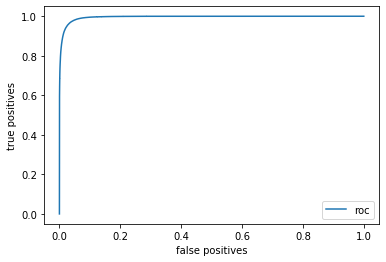

In [40]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_test,batch_size=2048)
auc = roc_auc_score(y_test, pred)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_test, pred)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)
plt.legend()

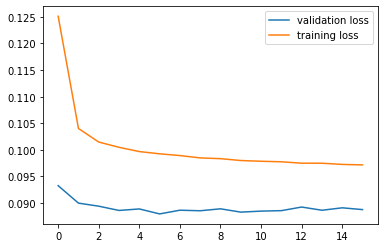

In [34]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

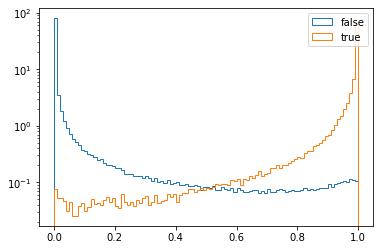

In [28]:
results = model.predict(X_test)
plt.hist(results[y_test==0], bins=100,density=True, label="false", histtype="step")
plt.hist(results[y_test==1], bins=100, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

# Some plots

In [4]:
from keras.models import load_model
model = load_model("models/model8_balanced.hd5")
scaler = pickle.load(open("models/scaler.pkl", "rb"))

Using TensorFlow backend.
W1218 02:15:44.216808 139892049925952 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1218 02:15:44.259624 139892049925952 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1218 02:15:44.296032 139892049925952 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1218 02:15:44.297456 139892049925952 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch

In [108]:
datas_val = []

for i in range(80, 127):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/numpy_v3/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    datas_val.append(d[(d.is_calo) & (d.is_seed == False)])
        
data_val  = pd.concat(datas_val, ignore_index=True)

cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster"]

In [35]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve
y_test = np.array(data_val.in_scluster, dtype=int)
pred = data_val["y"].values
auc = roc_auc_score(y_test,pred)
print("AUC score: " + str(auc))


>>> Computing AUC...


NameError: name 'data_val' is not defined

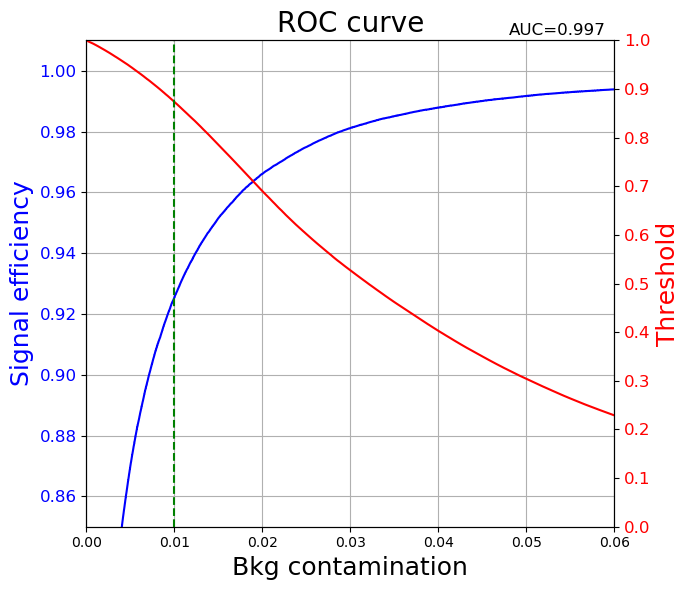

In [105]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

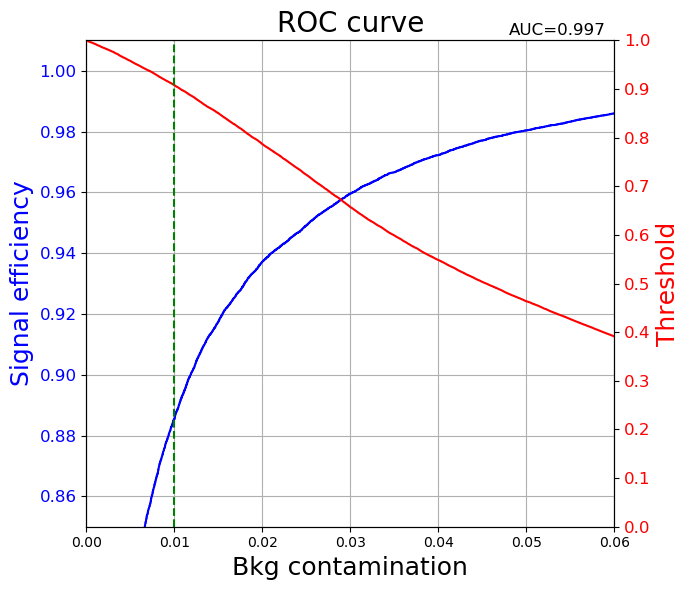

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

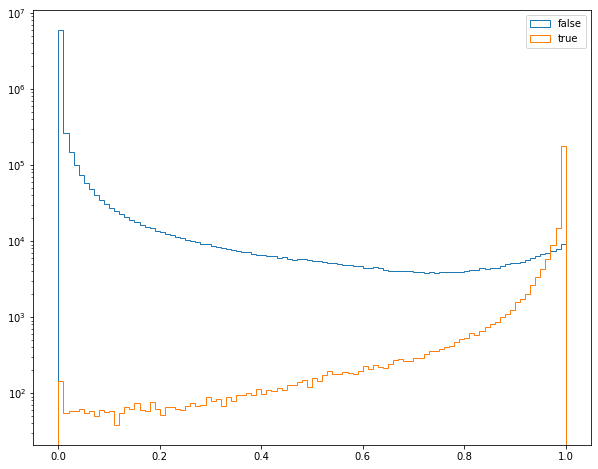

In [34]:
plt.hist(data_out["y"], bins=100, label="false", histtype="step")
plt.hist(data_in["y"], bins=100, label="true", histtype="step")
plt.yscale("log")
plt.legend()

(-0.6, 0.6)

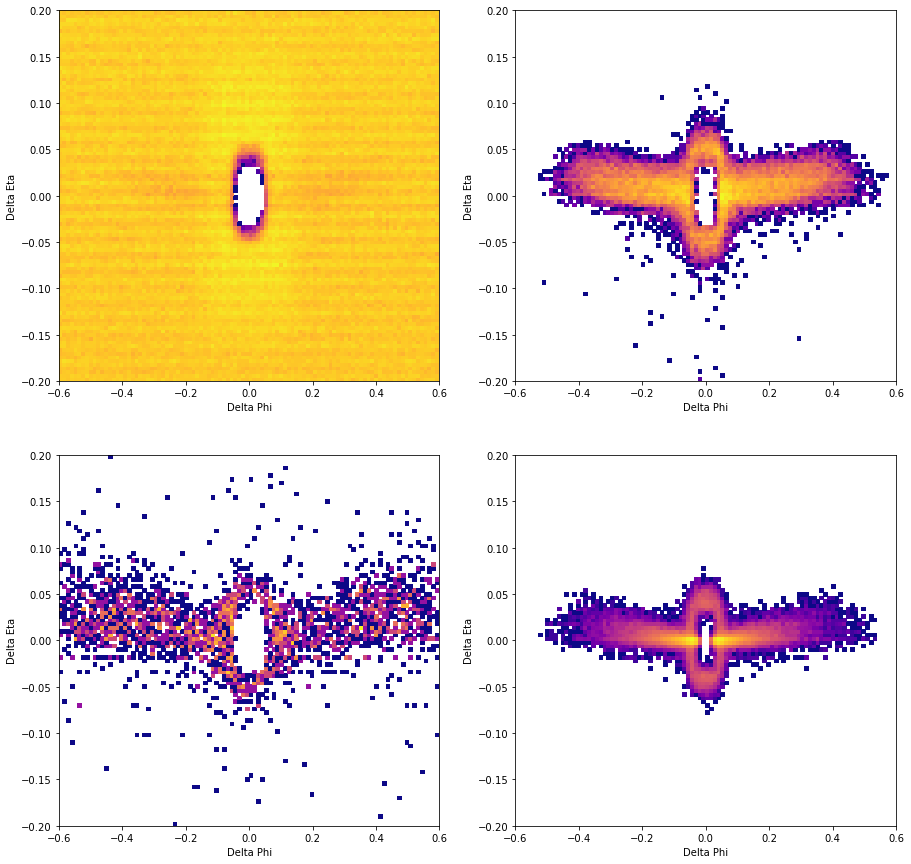

In [48]:
tr = 0.8
data_out_0 = data_out[data_out.y < tr]
data_out_1 = data_out[data_out.y > tr]
data_in_0 = data_in[data_in.y < tr]
data_in_1 = data_in[data_in.y > tr]

eta_min = 0
eta_max = 1
nbins = 100
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0][0].hist2d(data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_deta,
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][1].hist2d(data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][0].hist2d(data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][1].hist2d(data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_deta,   
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][0].set_ylabel("Delta Eta")
ax[0][0].set_xlabel("Delta Phi")
ax[1][0].set_ylabel("Delta Eta")
ax[1][0].set_xlabel("Delta Phi")
ax[0][1].set_ylabel("Delta Eta")
ax[0][1].set_xlabel("Delta Phi")
ax[1][1].set_ylabel("Delta Eta")
ax[1][1].set_xlabel("Delta Phi")

ax[1][0].set_ylim(-0.2, 0.2)
ax[1][0].set_xlim(-0.6,0.6)
ax[0][0].set_ylim(-0.2, 0.2)
ax[0][0].set_xlim(-0.6,0.6)
ax[1][1].set_ylim(-0.2, 0.2)
ax[1][1].set_xlim(-0.6,0.6)
ax[0][1].set_ylim(-0.2, 0.2)
ax[0][1].set_xlim(-0.6,0.6)

## energy resolution plot

In [4]:
from keras.models import load_model
model = load_model("models/model8_balanced.hd5")
scaler = pickle.load(open("models/scaler.pkl", "rb"))

Using TensorFlow backend.
W1218 09:40:33.443091 139772211664704 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1218 09:40:33.477302 139772211664704 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1218 09:40:33.512229 139772211664704 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1218 09:40:33.513756 139772211664704 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch

In [2]:
datas_val = []

for i in range(80, 125):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/numpy_v3/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    # KEEP also seed
    datas_val.append(d[(d.is_calo)])
        
data_val  = pd.concat(datas_val, ignore_index=True)

cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster"]

In [5]:
data_val["y"] = model.predict(scaler.transform(data_val[cols].values), batch_size=2048)

data_out = data_val[data_val.in_scluster== False]
data_in = data_val[data_val.in_scluster == True]

In [75]:
thresholds = [0.7,0.8,0.85, 0.873,0.9,0.95,0.99]

results = {}

for t in thresholds:

    g = data_val[(data_val.y >  t) | (data_val.is_seed==True)].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum', 
                          "en_true": "min", 
                          "en_seed": "first",
                          "seed_eta": "first",
                          "seed_phi": "first"})
    g["ratio"] = g["en_cluster"] / g["en_true"]
    
    results[t] = g

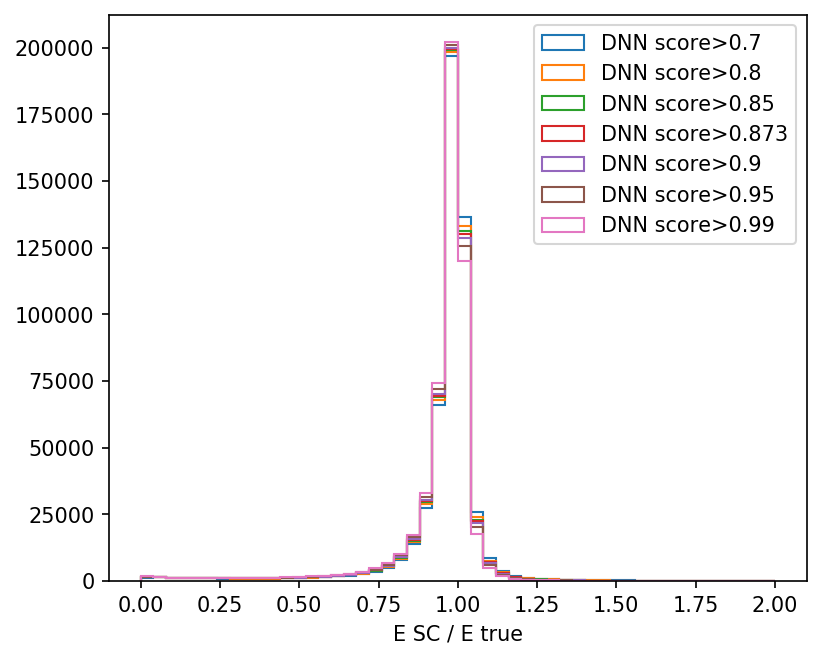

In [76]:
fig, _ = plt.subplots(figsize=(6,5), dpi=150)
for t , g in results.items():
    plt.hist(g.ratio, range=(0,2), bins=50,  histtype="step", label=f"DNN score>{t}",)
plt.xlabel("E SC / E true")
plt.legend()

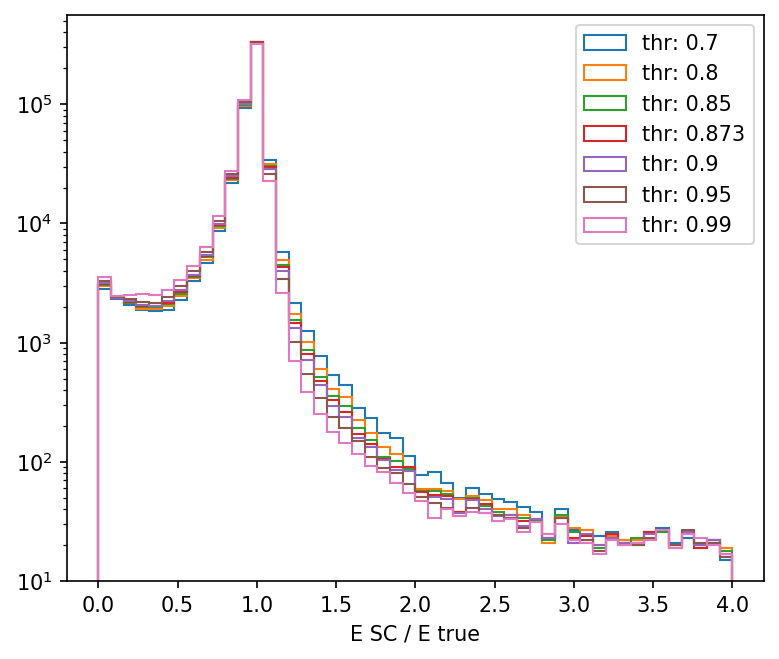

In [77]:
fig, _ = plt.subplots(figsize=(6,5), dpi=150)
for t , g in results.items():
    plt.hist(g.ratio, range=(0,4), bins=50,  histtype="step", label=f"thr: {t}", log=True, bottom=10)
plt.xlabel("E SC / E true")
plt.legend()

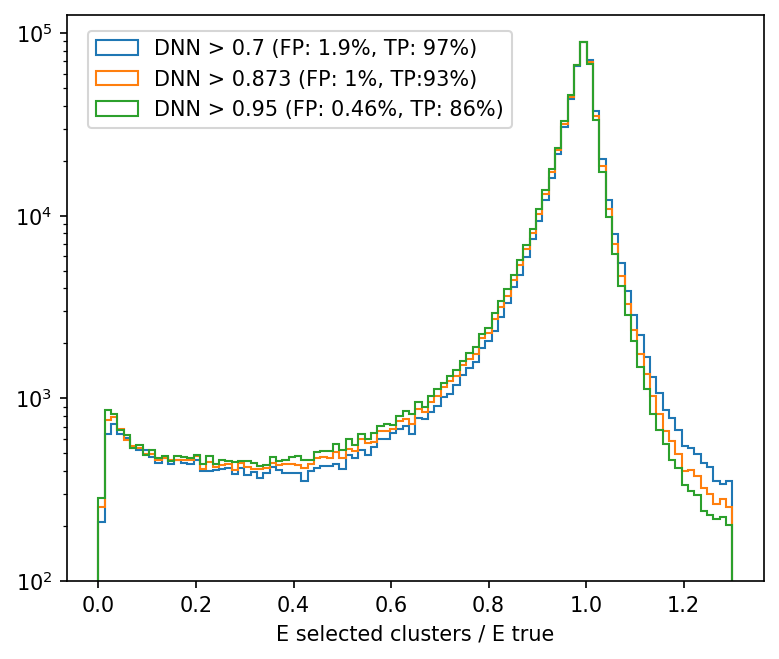

In [78]:
fig, ax = plt.subplots(figsize=(6,5), dpi=150)

info =    {0.7: "FP: 1.9%, TP: 97%", 
           0.873: "FP: 1%, TP:93%",
           0.95: "FP: 0.46%, TP: 86%"}

for t , g in results.items():
    if t  not in [0.7, 0.873, 0.95]: continue
    ax.hist(g.ratio, range=(0,1.3), bins=100,  histtype="step", label=f"DNN > {t} ({info[t]})", log=True, bottom=1e2)
ax.set_xlabel("E selected clusters / E true")
ax.legend(loc=(0.03, 0.8))

In [81]:
g.ratio.std()

138.9633526008959

In [79]:
for t , g in results.items():
    print(f"threshold: {t}, RMS: {g.ratio.std()}, resolution: {g.ratio.std() / g.ratio.mean()}")

threshold: 0.7, RMS: 142.288768152346, resolution: 89.38494401326679
threshold: 0.8, RMS: 142.01372128909054, resolution: 90.31637503992452
threshold: 0.85, RMS: 141.93569601981247, resolution: 90.71019311537945
threshold: 0.873, RMS: 141.9348776945353, resolution: 90.8377719758193
threshold: 0.9, RMS: 141.90595998637434, resolution: 91.11704988039745
threshold: 0.95, RMS: 141.89189814638686, resolution: 91.57289014357212
threshold: 0.99, RMS: 138.9633526008959, resolution: 91.723377491244


# Energy resolution scan

In [117]:
etas = [0, 0.2, 0.4 ,0.6, 0.8, 1, 1.2, 1.4, 1.479, 1.75, 2, 2.25, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


t = 0.95
g = data_val[(data_val.y >  t) | (data_val.is_seed==True)].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum', 
                          "en_true": "min", 
                          "en_seed": "first",
                          "seed_eta": "first",
                          "seed_phi": "first"})
g["ratio"] = g["en_cluster"] / g["en_true"]
g["et_seed"] = g.en_seed / np.cosh(g.seed_eta)
g["eta_bin"] = pd.cut(abs(g.seed_eta), etas)
g["en_bin"] = pd.cut(g.et_seed, ens)

scanres = g.groupby(["eta_bin", "en_bin"]).agg({"ratio": ["mean", "std"], "en_cluster": "std", "en_true": "mean"})
scanres["res"] = scanres["en_cluster", "std"] / scanres["en_true", "mean"]
resolutions = np.reshape(scanres["res"].values, (len(etas)-1, len(ens)-1))

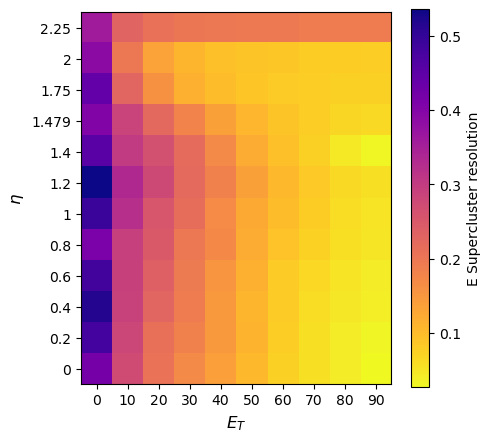

In [118]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)
im =  ax.imshow(resolutions, cmap="plasma_r")
ax.set_xticks(np.arange(len(ens)-1))
ax.set_yticks(np.arange(len(etas)-1))
ax.set_yticklabels(etas)
ax.set_xticklabels(ens)
ax.set_xlabel("$E_T$", fontsize="large")
ax.set_ylabel("$\eta$", fontsize="large")
plt.colorbar(im, ax=ax,label="E Supercluster resolution")

#  Efficiencies scan eta, en

In [239]:
etas = [0, 0.2, 0.4 ,0.6, 0.8, 1, 1.2, 1.4, 1.479, 1.75, 2, 2.25, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#etas = [0, 1, 2]
#ens= [0, 50, 100]
threshold = 0.873

results = np.zeros((len(etas)-1, len(ens)-1, 2))

data_in = data_in[data_in.is_seed==False]
data_out = data_out[data_out.is_seed==False]

for ieta in range(len(etas)-1):
    for ien in range(len(ens)-1):
        eta_min = etas[ieta]
        eta_max = etas[ieta+1]
        et_min = ens[ien]
        et_max = ens[ien+1]
        print(eta_min, eta_max, et_min, et_max)
        
        data_out_tot = data_out[(abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ].size
        data_out_1 = data_out[(data_out.y > threshold) & (abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ].size
        data_in_tot = data_in[ (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ].size
        data_in_1 = data_in[(data_in.y > threshold) & (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ].size
        
        results[ieta, ien, :] = np.array([data_in_1 / data_in_tot , data_out_1 / data_out_tot])

0 0.2 0 10
0 0.2 10 20
0 0.2 20 30
0 0.2 30 40
0 0.2 40 50
0 0.2 50 60
0 0.2 60 70
0 0.2 70 80
0 0.2 80 90
0 0.2 90 100
0.2 0.4 0 10
0.2 0.4 10 20
0.2 0.4 20 30
0.2 0.4 30 40
0.2 0.4 40 50
0.2 0.4 50 60
0.2 0.4 60 70
0.2 0.4 70 80
0.2 0.4 80 90
0.2 0.4 90 100
0.4 0.6 0 10
0.4 0.6 10 20
0.4 0.6 20 30
0.4 0.6 30 40
0.4 0.6 40 50
0.4 0.6 50 60
0.4 0.6 60 70
0.4 0.6 70 80
0.4 0.6 80 90
0.4 0.6 90 100
0.6 0.8 0 10
0.6 0.8 10 20
0.6 0.8 20 30
0.6 0.8 30 40
0.6 0.8 40 50
0.6 0.8 50 60
0.6 0.8 60 70
0.6 0.8 70 80
0.6 0.8 80 90
0.6 0.8 90 100
0.8 1 0 10
0.8 1 10 20
0.8 1 20 30
0.8 1 30 40
0.8 1 40 50
0.8 1 50 60
0.8 1 60 70
0.8 1 70 80
0.8 1 80 90
0.8 1 90 100
1 1.2 0 10
1 1.2 10 20
1 1.2 20 30
1 1.2 30 40
1 1.2 40 50
1 1.2 50 60
1 1.2 60 70
1 1.2 70 80
1 1.2 80 90
1 1.2 90 100
1.2 1.4 0 10
1.2 1.4 10 20
1.2 1.4 20 30
1.2 1.4 30 40
1.2 1.4 40 50
1.2 1.4 50 60
1.2 1.4 60 70
1.2 1.4 70 80
1.2 1.4 80 90
1.2 1.4 90 100
1.4 1.479 0 10
1.4 1.479 10 20
1.4 1.479 20 30
1.4 1.479 30 40
1.4 1.479 40 50
1

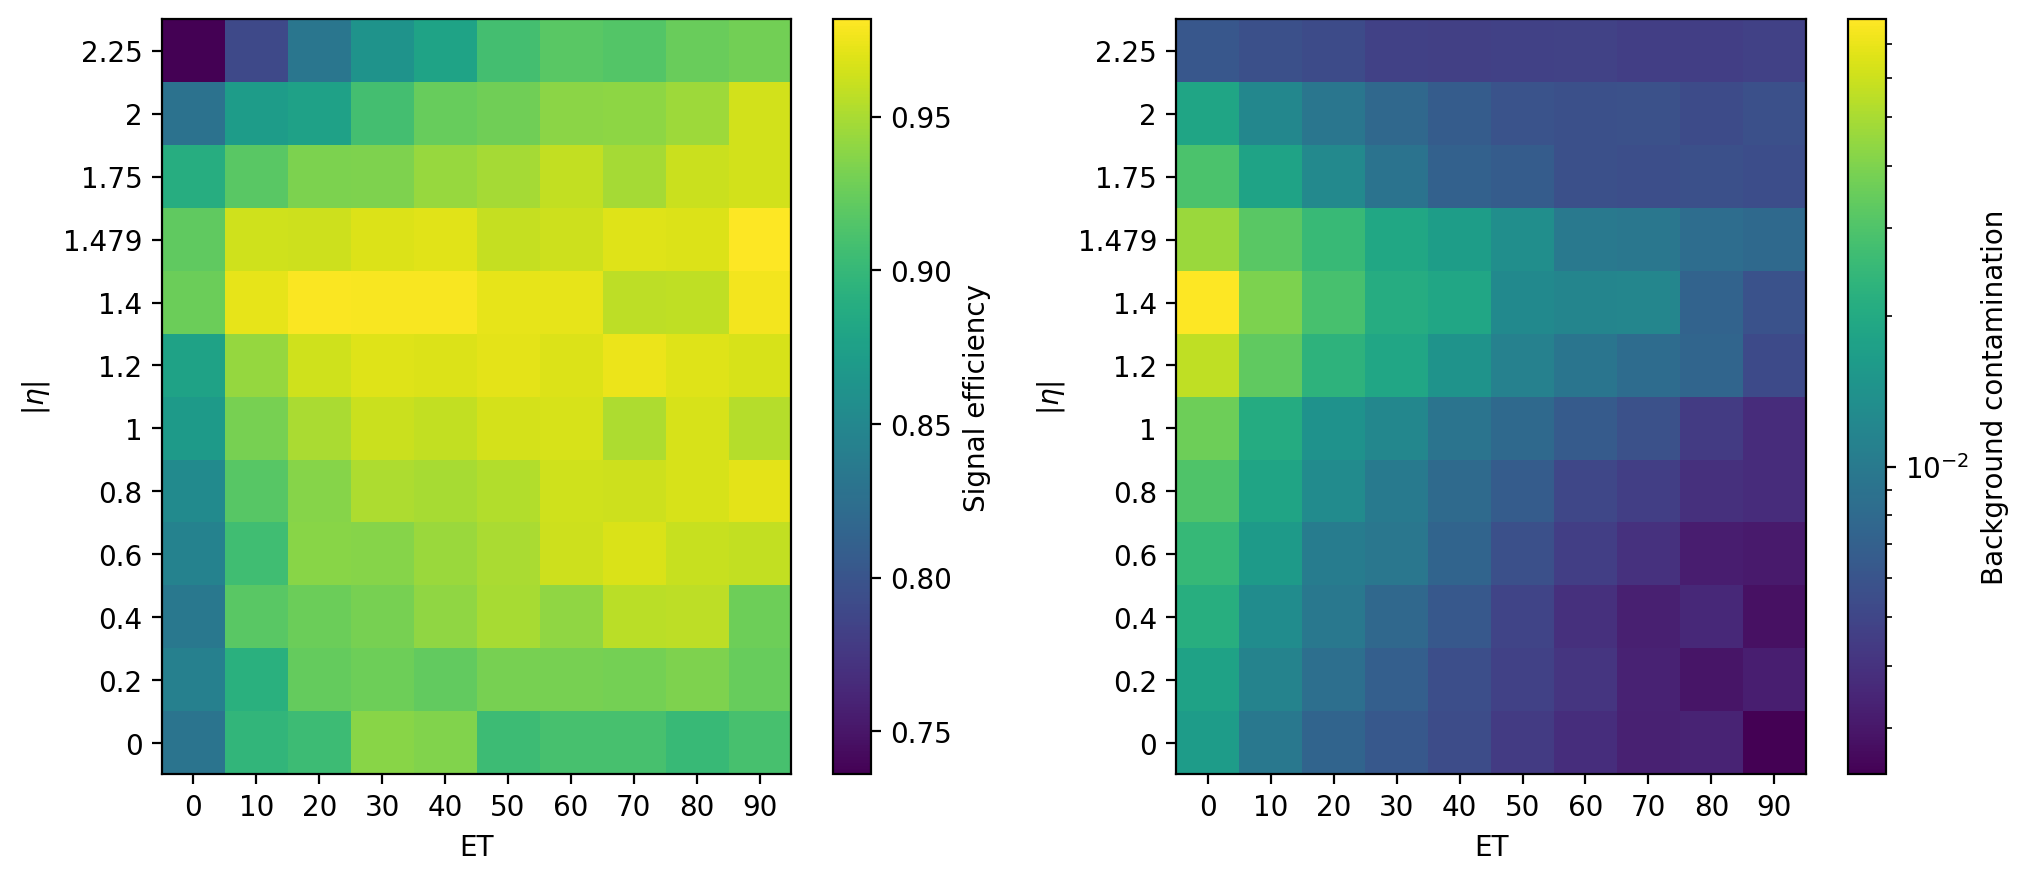

In [279]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12,5), dpi=200)
im = ax1.imshow(results[:,:,0])
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1, label="Signal efficiency")

im2 = ax2.imshow(results[:,:,1], norm=colors.LogNorm())
ax2.set_xticks(np.arange(len(ens)-1))
ax2.set_yticks(np.arange(len(etas)-1))
ax2.set_yticklabels(etas)
ax2.set_xticklabels(ens)
ax2.set_xlabel("ET")
ax2.set_ylabel("$|\eta|$")
fig.colorbar(im2, ax=ax2, label="Background contamination")

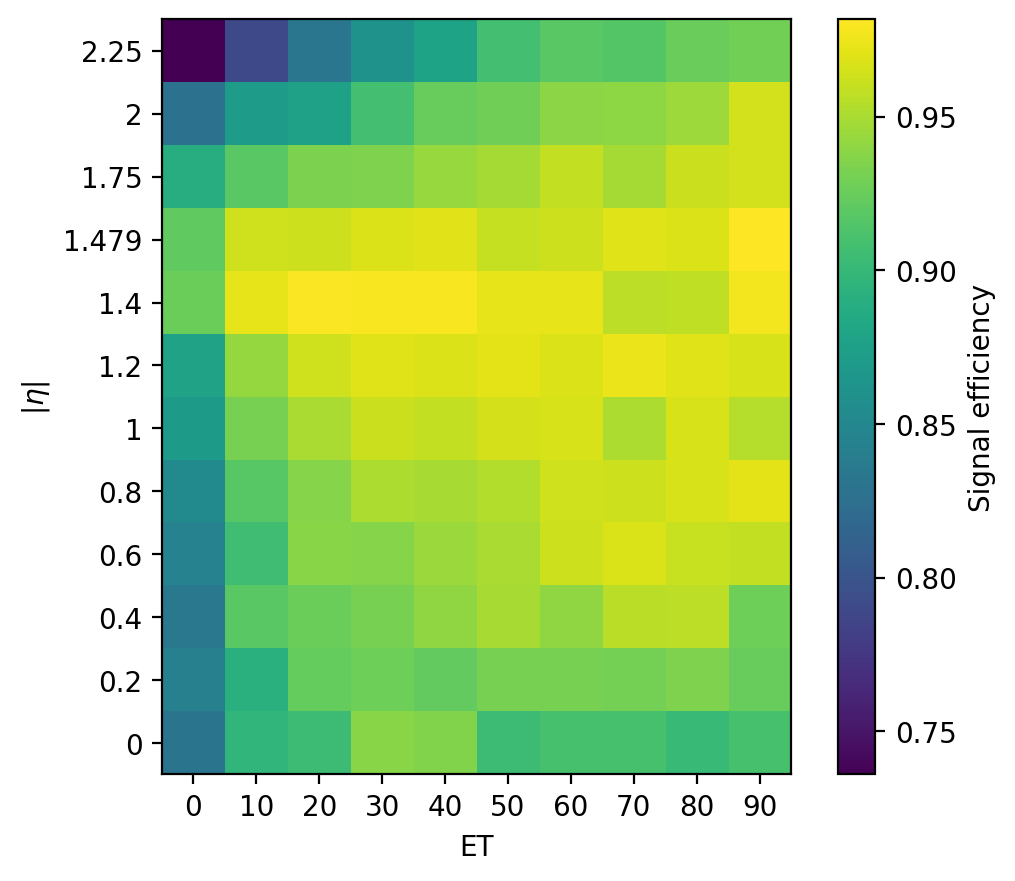

In [285]:
fig,ax1 = plt.subplots(figsize=(6,5), dpi=200)
im = ax1.imshow(results[:,:,0])
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1, label="Signal efficiency")


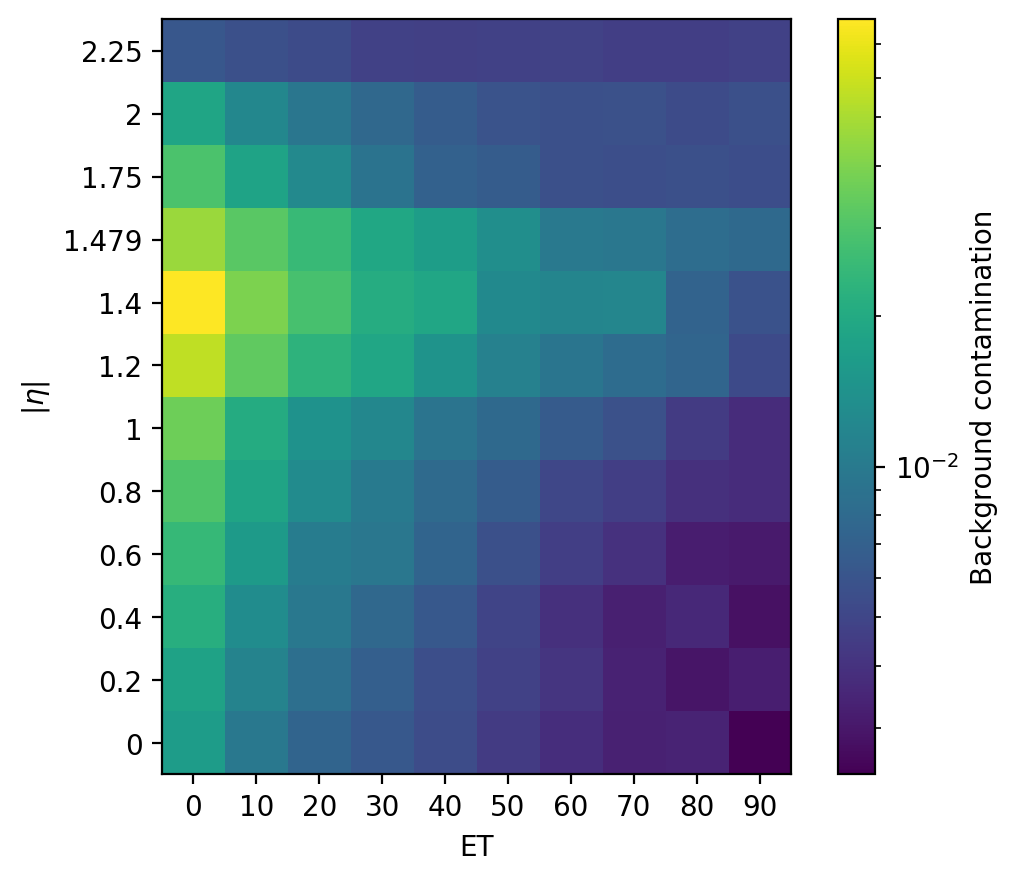

In [283]:
fig,ax2 = plt.subplots(figsize=(6,5), dpi=200)

im2 = ax2.imshow(results[:,:,1], norm=colors.LogNorm())
ax2.set_xticks(np.arange(len(ens)-1))
ax2.set_yticks(np.arange(len(etas)-1))
ax2.set_yticklabels(etas)
ax2.set_xticklabels(ens)
ax2.set_xlabel("ET")
ax2.set_ylabel("$|\eta|$")
fig.colorbar(im2, ax=ax2, label="Background contamination")

# Phoenix plot

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion(threshold, eta_bins, et_bins, axlim=(0.6, 0.2)):
    eta_min, eta_max = eta_bins
    et_min, et_max = et_bins
    data_out_0 = data_out[(data_out.y < threshold) & (abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                        (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ]
    data_out_1 = data_out[(data_out.y > threshold) & (abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                        (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ]
    data_in_0 = data_in[(data_in.y < threshold) & (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                        (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ]
    data_in_1 = data_in[(data_in.y > threshold) & (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                        (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ]
    nbins = 80
    
    fig = plt.figure(figsize=(7,8), dpi=200)

    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2, sharey = ax1)  #Share y-axes with subplot 1
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4, sharey = ax3)  #Share y-axes with subplot 1
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax4.get_yticklabels(), visible=False)
    
    #size = max([ data_out_0.size / 80**2, data_out_1.size / 80**2,data_in_0.size / 80**2, data_in_1.size / 80**2])
    
    h, *_, h11 = ax4.hist2d(data_in_1.cluster_dphi, data_in_1.cluster_deta,   
                    bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
    
    size = np.max(h)
    *_, h00= ax1.hist2d(data_out_0.cluster_dphi, data_out_0.cluster_deta,
                     bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), vmax=size, cmap="plasma", norm=colors.LogNorm())
    *_, h01 = ax2.hist2d(data_out_1.cluster_dphi, data_out_1.cluster_deta,  
                     bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), vmax=size,cmap="plasma", norm=colors.LogNorm())
    *_, h10 = ax3.hist2d(data_in_0.cluster_dphi, data_in_0.cluster_deta,  
                    bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), vmax=size,cmap="plasma", norm=colors.LogNorm())
    
    #fig.colorbar(h00, ax=ax[0][0])
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.delaxes(cax1)
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h01, cax=cax2, label="N. clusters")
    
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    fig.delaxes(cax3)
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h11, cax=cax4, label="N. clusters")
    
    ax1.set_ylabel("$\Delta \eta$")
    ax1.set_xlabel("$\Delta \phi$")
    ax2.set_xlabel("$\Delta \phi$")
    #ax2.set_ylabel("Delta Eta")
    ax3.set_ylabel("$\Delta \eta$")
    ax3.set_xlabel("$\Delta \phi$")
    ax4.set_xlabel("$\Delta \phi$")
    #ax4.set_ylabel("Delta Eta")

    ax1.set_xlim(-axlim[0], axlim[0])
    ax2.set_xlim(-axlim[0], axlim[0])
    ax3.set_xlim(-axlim[0], axlim[0])
    ax4.set_xlim(-axlim[0], axlim[0])
    ax1.set_ylim(-axlim[1], axlim[1])
    ax2.set_ylim(-axlim[1], axlim[1])
    ax3.set_ylim(-axlim[1], axlim[1])
    ax4.set_ylim(-axlim[1], axlim[1])
    
    plt.subplots_adjust(wspace = -.015, hspace=0.25)
    #plt.tight_layout()
    fig.text(0.5, 0.9, "Background", ha="center", va="center", fontsize="large")
    fig.text(0.5, 0.48, "Signal", ha="center", va="center",fontsize="large")
    fig.text(0.13, 0.89, f"Score < {threshold}", va="center")
    fig.text(0.13, 0.47, f"Score < {threshold}",va="center")
    fig.text(0.73, 0.89, f"Score > {threshold}", va="center")
    fig.text(0.73, 0.47, f"Score > {threshold}",va="center")
    
    fig.text(0.02, 0.93, f"${eta_min} < |\eta| < {eta_max}$, ${et_min} < E_{{T}}< {et_max}$", va="center", ha="left")

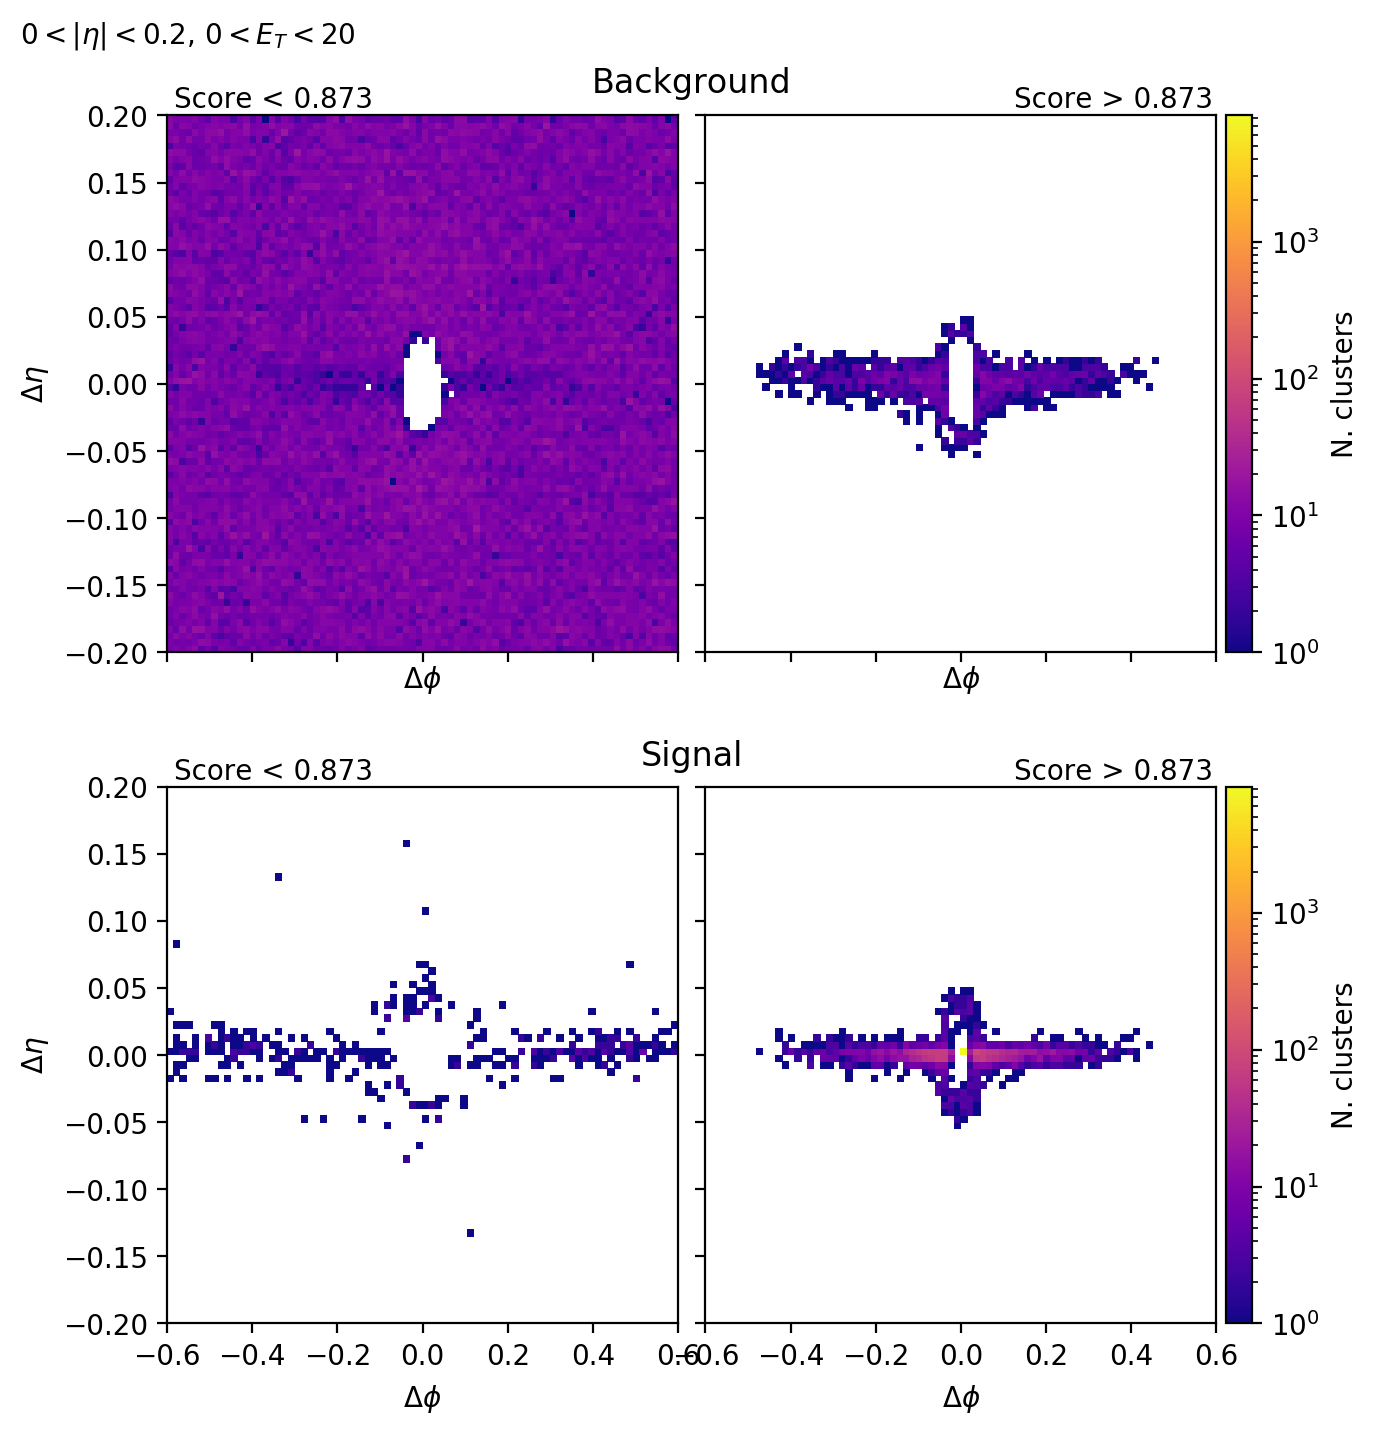

In [32]:
plot_confusion(0.873, (0,0.2), (0,20))